In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import os

from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.utilities.ts_gapfilling import ModelGapFiller, SimpleGapFiller

In [2]:
# Set up folder with data
os.chdir('D:\\01_PROJECTS_sripts_code\\Electricty_Demand\\Download_and_Prepare_Data')

# Set up max disply rows
pd.options.display.max_rows = 12

In [3]:
##########################################################
##########################################################
#%% Electricty demand data
##########################################################
##########################################################

In [4]:
###################
#%% Read and Basic Process
###################

In [6]:
# Read data without a time zone info
TexasDemandData_Raw = pd.read_csv('Electricity_Demand_Texas_data.csv',\
                                  parse_dates =['Date'],
                                  index_col = 'Date',
                                  date_parser=lambda x: pd.to_datetime(x.rpartition('-')[0]) )

TexasDemandData_Raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65195 entries, 2022-12-09 10:00:00 to 2015-07-01 01:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   65195 non-null  int64
dtypes: int64(1)
memory usage: 1018.7 KB


In [7]:
# Rename and sort
TexasDemandData = TexasDemandData_Raw\
                        .rename(columns = {'value':'Demand'})\
                        .sort_index()

# Show data
TexasDemandData

,Demand
Date,
2015-07-01 01:00:00,37456
2015-07-01 02:00:00,35119
2015-07-01 03:00:00,33638
2015-07-01 04:00:00,32798
2015-07-01 05:00:00,32805
...,...
2022-12-09 06:00:00,37635
2022-12-09 07:00:00,40596
2022-12-09 08:00:00,41978


In [8]:
# Show duplicated indexes <- after removing time zone info them appeared based on time change
print( TexasDemandData[ TexasDemandData.index.duplicated() ] )

# Remove duplicated values in time change points
TexasDemandData = TexasDemandData.groupby('Date').mean()

# Take first and last observations
FirstDemandObserwation = TexasDemandData.index[0]
LastDemandObserwation = TexasDemandData.index[-1]

# Fill data with 'H' frequency
TexasDemandData = TexasDemandData.asfreq('H')

                     Demand
Date                       
2015-11-01 01:00:00   27098
2016-11-06 01:00:00   28456
2017-11-05 01:00:00   35487
2018-11-04 01:00:00   29383
2019-11-03 01:00:00   33457
2020-11-01 01:00:00   30575
2021-11-07 01:00:00   33861
2022-11-06 01:00:00   34898


In [9]:
###################
#%% Check and fill NA
###################

In [10]:
# Check NA
TexasDemandData.isna().sum()

Demand    55
dtype: int64

In [11]:
# Take indexes for NA
TexasDemandData_NA = TexasDemandData[TexasDemandData.isna().any(axis=1)]
IndexNA = TexasDemandData_NA.index

print(IndexNA)
# There are 2 zone with NAs and also in all years a 1 hour with NA in march caused by time change

DatetimeIndex(['2016-03-13 02:00:00', '2017-03-12 02:00:00',
               '2018-03-11 02:00:00', '2018-07-01 01:00:00',
               '2018-07-01 02:00:00', '2018-07-01 03:00:00',
               '2018-07-01 04:00:00', '2018-07-01 05:00:00',
               '2018-07-01 06:00:00', '2018-07-01 07:00:00',
               '2018-07-01 08:00:00', '2018-07-01 09:00:00',
               '2018-07-01 10:00:00', '2018-07-01 11:00:00',
               '2018-07-01 12:00:00', '2018-07-01 13:00:00',
               '2018-07-01 14:00:00', '2018-07-01 15:00:00',
               '2018-07-01 16:00:00', '2018-07-01 17:00:00',
               '2018-07-01 18:00:00', '2018-07-01 19:00:00',
               '2018-07-01 20:00:00', '2018-07-01 21:00:00',
               '2018-07-01 22:00:00', '2018-07-01 23:00:00',
               '2018-07-02 00:00:00', '2018-11-11 01:00:00',
               '2018-11-11 02:00:00', '2018-11-11 03:00:00',
               '2018-11-11 04:00:00', '2018-11-11 05:00:00',
               '2018-11-

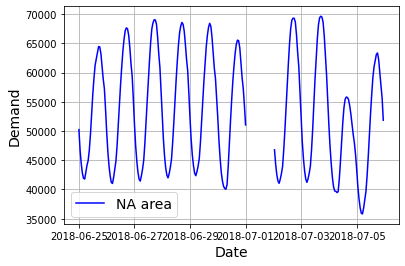

In [12]:
# Show NA 1-st region
Start_period = '2018-06-25'
End_period = '2018-07-05'

plt.plot(TexasDemandData.loc[Start_period:End_period], c='blue', alpha=1.0,  label='NA area')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

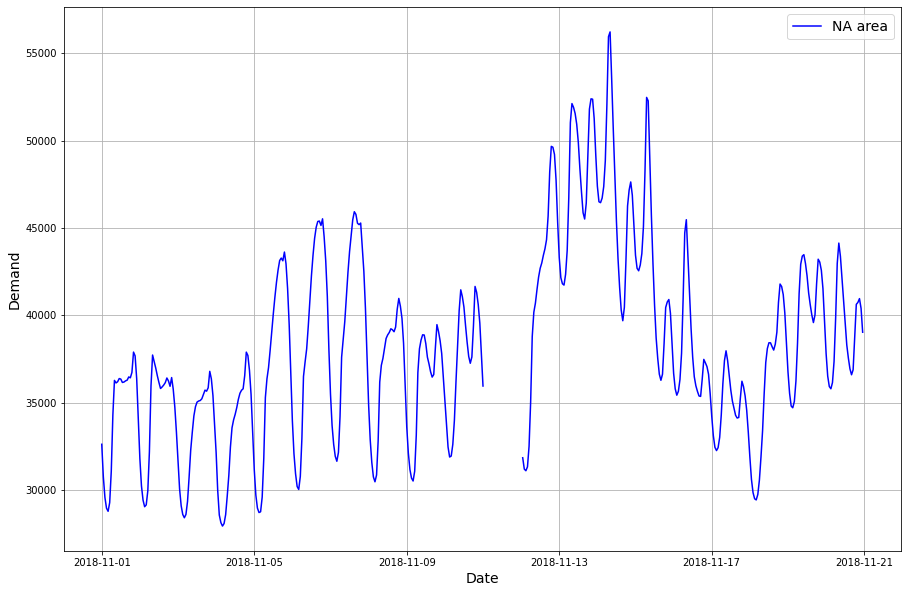

In [13]:
# Show NA 2-nd region
Start_period = '2018-11-01'
End_period = '2018-11-20'

plt.plot(TexasDemandData.loc[Start_period:End_period], c='blue', alpha=1.0,  label='NA area')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [14]:
# Fill NA in Demand data using interpolation based on FEDOT
# https://github.com/ITMO-NSS-team/fedot-examples/blob/main/notebooks/latest/5_ts_specific_cases.ipynb

In [15]:
# Function for creating pipeline
def get_simple_ridge_pipeline():
    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': 168}

    node_final = SecondaryNode('ridge', nodes_from=[node_lagged])
    pipeline = Pipeline(node_final)

    return pipeline

pipeline = get_simple_ridge_pipeline()
# Relate NA with value -100
model_gapfiller = ModelGapFiller(gap_value=-100.0,
                                 pipeline=pipeline)


# Create array to fill were NA is indicated by '-100'
array_with_gaps  = np.array(TexasDemandData.replace(np.nan, -100)['Demand'])

# Fill NA
TexasDemandData_Filled = model_gapfiller.forward_inverse_filling(array_with_gaps)

# Create new colum with filled data
TexasDemandData['filled'] = TexasDemandData_Filled

In [16]:
# Take only Filled data to show it on a plot
Fillled_Only = pd.DataFrame( data = TexasDemandData_Filled, index = TexasDemandData.index, columns = ['Filled'] )\
                    .loc[IndexNA]

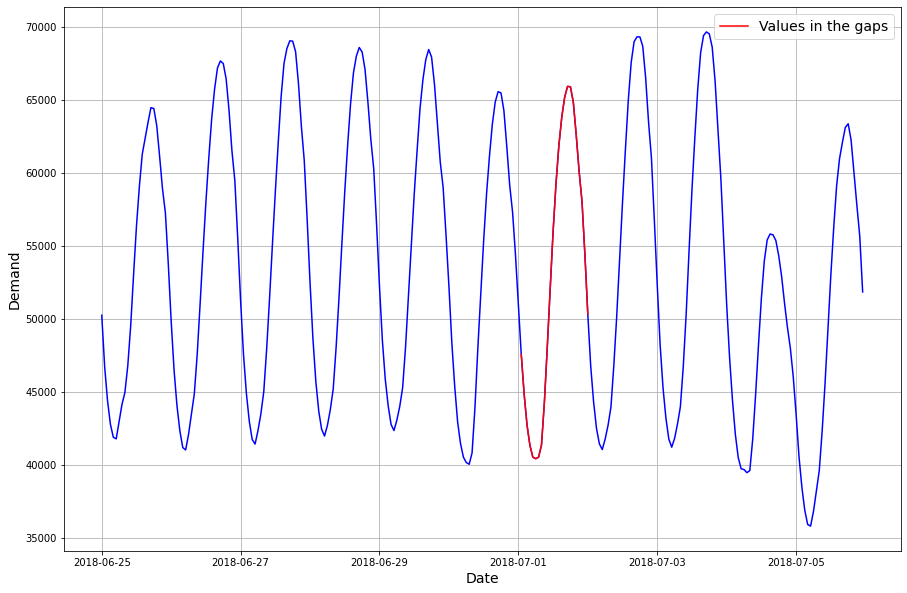

In [17]:
# Plot 1-st filled gap
Start_period = '2018-06-25'
End_period = '2018-07-05'

plt.plot(TexasDemandData['filled'].loc[Start_period:End_period], c='blue', alpha=1.0)
plt.plot(Fillled_Only.loc[Start_period:End_period], c='red', alpha=1.0, label='Values in the gaps')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

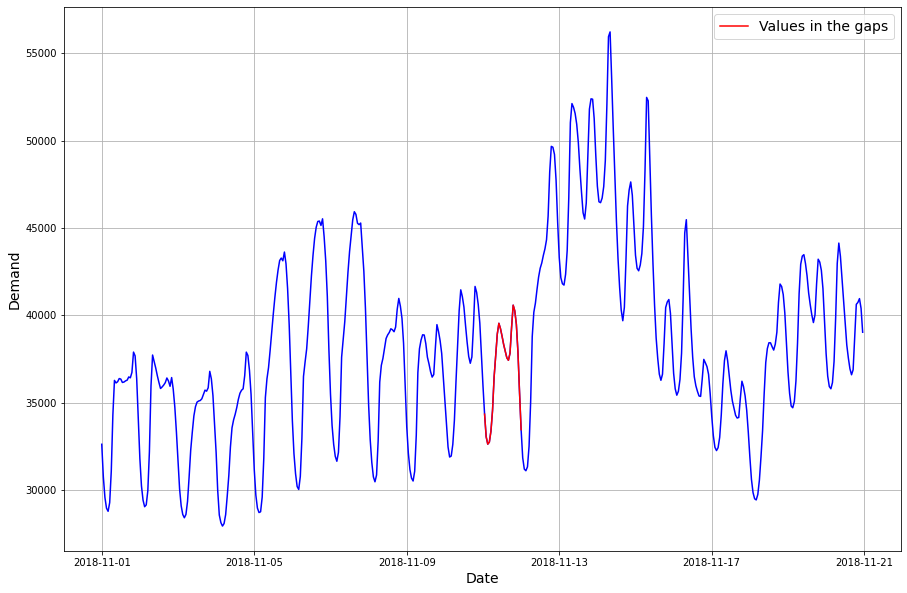

In [18]:
# Plot 2-nd filled gap
Start_period = '2018-11-01'
End_period = '2018-11-20'

plt.plot(TexasDemandData['filled'].loc[Start_period:End_period], c='blue', alpha=1.0)
plt.plot(Fillled_Only.loc[Start_period:End_period], c='red', alpha=1.0, label='Values in the gaps')
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [19]:
# Show finall data
TexasDemandData

,Demand,filled
Date,,
2015-07-01 01:00:00,37456.0,37456.0
2015-07-01 02:00:00,35119.0,35119.0
2015-07-01 03:00:00,33638.0,33638.0
2015-07-01 04:00:00,32798.0,32798.0
2015-07-01 05:00:00,32805.0,32805.0
...,...,...
2022-12-09 06:00:00,37635.0,37635.0
2022-12-09 07:00:00,40596.0,40596.0
2022-12-09 08:00:00,41978.0,41978.0


<AxesSubplot:xlabel='Date'>

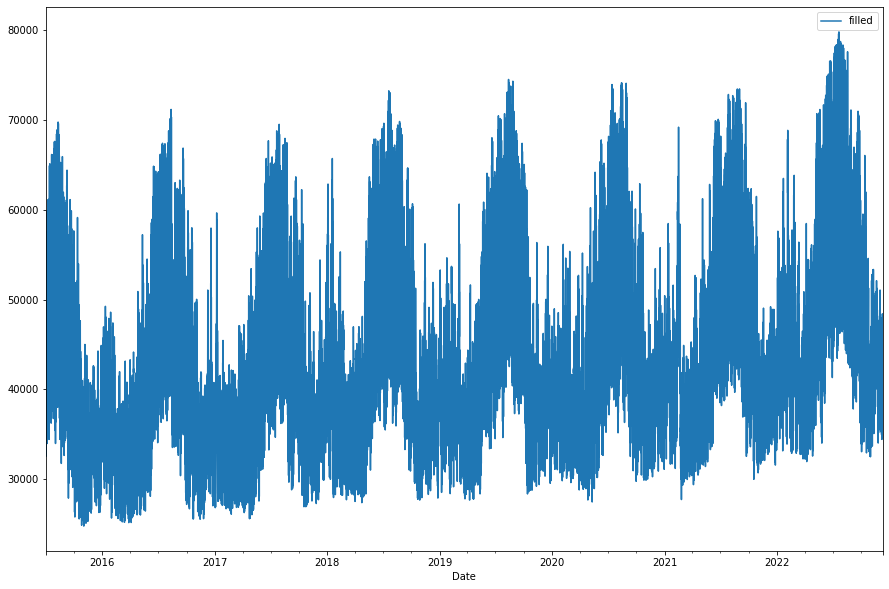

In [20]:
# Plot Finall data
TexasDemandData[['filled']].plot()

In [21]:
############################################################################
############################################################################
#%% Whether data
############################################################################
############################################################################

In [22]:
###################
#%% Read and Basic Process
###################

In [23]:
# Read data
AustinWheatherData_Raw = pd.read_csv('Austin_wheather_data_OpenMeteo.csv',\
                                     parse_dates =['dateTime'])

# Show columns
AustinWheatherData_Raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113324 entries, 0 to 113323
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   dateTime              113324 non-null  datetime64[ns]
 1   air_temperature       113324 non-null  float64       
 2   humidity              113324 non-null  float64       
 3   apparent_temperature  113324 non-null  float64       
 4   sky_cover             113324 non-null  float64       
 5   shortwave_radiation   113324 non-null  float64       
 6   wind_speed            113324 non-null  float64       
 7   wind_direction        113311 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.9 MB


In [24]:
# Show data
AustinWheatherData_Raw

,dateTime,air_temperature,humidity,apparent_temperature,sky_cover,shortwave_radiation,wind_speed,wind_direction
0,2010-01-01 00:00:00,6.8,69.0,1.5,64.0,0.0,23.1,342.0
1,2010-01-01 01:00:00,6.7,70.0,1.4,44.0,0.0,23.2,341.0
2,2010-01-01 02:00:00,5.8,70.0,0.7,16.0,0.0,21.2,339.0
3,2010-01-01 03:00:00,4.2,69.0,-0.8,1.0,0.0,18.6,345.0
4,2010-01-01 04:00:00,2.7,71.0,-1.9,0.0,0.0,14.3,350.0
...,...,...,...,...,...,...,...,...
113319,2022-12-05 15:00:00,24.5,68.0,24.4,91.0,285.0,21.9,243.0
113320,2022-12-05 16:00:00,24.0,70.0,24.7,60.0,150.0,15.8,243.0
113321,2022-12-05 17:00:00,24.0,70.0,25.0,36.0,83.0,13.2,241.0
113322,2022-12-05 18:00:00,23.1,74.0,24.2,21.0,6.0,12.3,238.0


In [25]:
# Rename, set index and select columns
AustinWheatherData = AustinWheatherData_Raw.copy()\
                            .rename(columns = {'dateTime':'Date'})\
                            .set_index('Date')\
                            [['air_temperature', 'humidity', 'sky_cover', 'wind_speed']]
            
AustinWheatherData = AustinWheatherData.loc[FirstDemandObserwation:]

In [26]:
# Fill data with 'H' frequency to check NA
AustinWheatherData = AustinWheatherData.asfreq('H')

# Check NA
AustinWheatherData.isna().sum()

air_temperature    0
humidity           0
sky_cover          0
wind_speed         0
dtype: int64

In [27]:
# Show finall data
AustinWheatherData

,air_temperature,humidity,sky_cover,wind_speed
Date,,,,
2015-07-01 01:00:00,23.0,95.0,14.0,11.5
2015-07-01 02:00:00,22.9,96.0,26.0,11.3
2015-07-01 03:00:00,22.8,95.0,22.0,10.9
2015-07-01 04:00:00,22.6,96.0,7.0,9.4
2015-07-01 05:00:00,22.5,96.0,5.0,7.1
...,...,...,...,...
2022-12-05 15:00:00,24.5,68.0,91.0,21.9
2022-12-05 16:00:00,24.0,70.0,60.0,15.8
2022-12-05 17:00:00,24.0,70.0,36.0,13.2


In [28]:
############################################################################
############################################################################
#%% TEXAS population
############################################################################
############################################################################

In [29]:
###################
#%% Read and Basic Process
###################

In [30]:
# Read raw data:
PopulationTexas_Raw = pd.read_csv('Population_Texas.csv',\
                              parse_dates =['date'])

PopulationTexas_Raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    122 non-null    datetime64[ns]
 1   value   122 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB


In [31]:
# Show data
PopulationTexas_Raw

,date,value
0,1900-01-01,3055000
1,1901-01-01,3132000
2,1902-01-01,3210000
3,1903-01-01,3291000
4,1904-01-01,3374000
...,...,...
117,2017-01-01,28291024
118,2018-01-01,28624564
119,2019-01-01,28986794
120,2020-01-01,29217653


In [32]:
# Rename, set index and select from first observation minus 1 year
PopulationTexas = PopulationTexas_Raw.copy()\
                            .rename(columns = {'date':'Date',\
                                               'value':'Population'})\
                            .set_index('Date')\
                            .loc[str(FirstDemandObserwation.year-1):]

In [33]:
# Show data
PopulationTexas

,Population
Date,
2014-01-01,26963092
2015-01-01,27468531
2016-01-01,27914064
2017-01-01,28291024
2018-01-01,28624564
2019-01-01,28986794
2020-01-01,29217653
2021-01-01,29527941


In [34]:
# Check NA
PopulationTexas.isna().sum()

Population    0
dtype: int64

<AxesSubplot:xlabel='Date'>

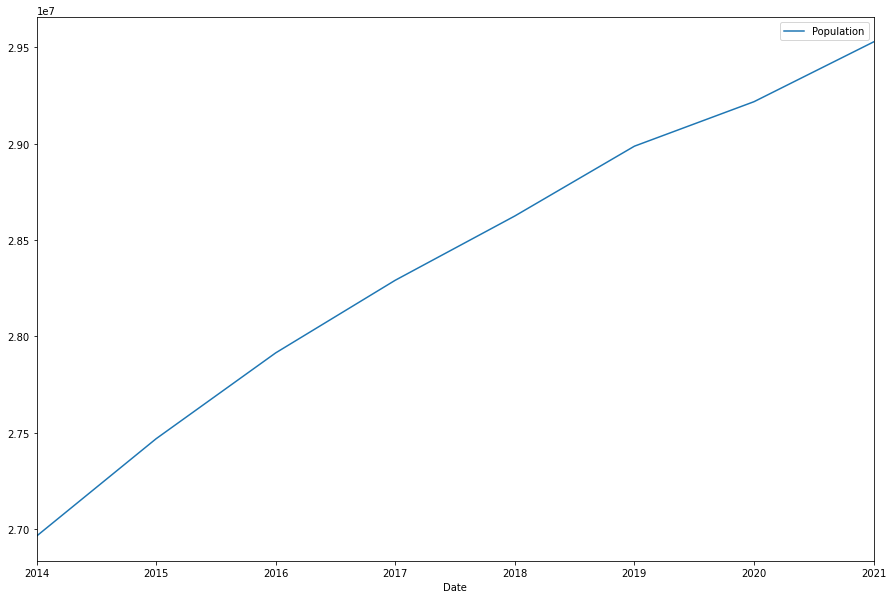

In [35]:
# Plot data 
PopulationTexas.plot()

In [36]:
# Create a function to add one observation based on linear trend
def AddEndElementWithSlope(DF):
    
    time = 1
    slope = (DF.iloc[-1] - DF.iloc[-2])/time
    
    DFin = DF.copy()

    DFin.loc[ DFin.index[-1] + pd.DateOffset(years=1) ] = np.nan
    DFin.iloc[-1] = slope*time+DF.iloc[-1]
    
    return DFin

# add one year based on linear trend
PopulationTexas = AddEndElementWithSlope(PopulationTexas)

In [37]:
# Move date to end of year, becouse population is calculated at end of year
print(PopulationTexas)
print('')
print('')

PopulationTexas.index = PopulationTexas.index + pd.offsets.YearEnd(0)

print('Data After Index Movement:')
print('')
print(PopulationTexas)

            Population
Date                  
2014-01-01  26963092.0
2015-01-01  27468531.0
2016-01-01  27914064.0
2017-01-01  28291024.0
2018-01-01  28624564.0
2019-01-01  28986794.0
2020-01-01  29217653.0
2021-01-01  29527941.0
2022-01-01  29838229.0


Data After Index Movement:

            Population
Date                  
2014-12-31  26963092.0
2015-12-31  27468531.0
2016-12-31  27914064.0
2017-12-31  28291024.0
2018-12-31  28624564.0
2019-12-31  28986794.0
2020-12-31  29217653.0
2021-12-31  29527941.0
2022-12-31  29838229.0


In [38]:
# Make data daily by inteprolation
PopulationTexas = PopulationTexas.asfreq('H')\
                                 .interpolate(method='time')

# Select date from 1-st observation
PopulationTexas = PopulationTexas.loc[FirstDemandObserwation:]

# Show finall Population Data
PopulationTexas

,Population
Date,
2015-07-01 01:00:00,2.721518e+07
2015-07-01 02:00:00,2.721523e+07
2015-07-01 03:00:00,2.721529e+07
2015-07-01 04:00:00,2.721535e+07
2015-07-01 05:00:00,2.721541e+07
...,...
2022-12-30 20:00:00,2.983809e+07
2022-12-30 21:00:00,2.983812e+07
2022-12-30 22:00:00,2.983816e+07


<AxesSubplot:xlabel='Date'>

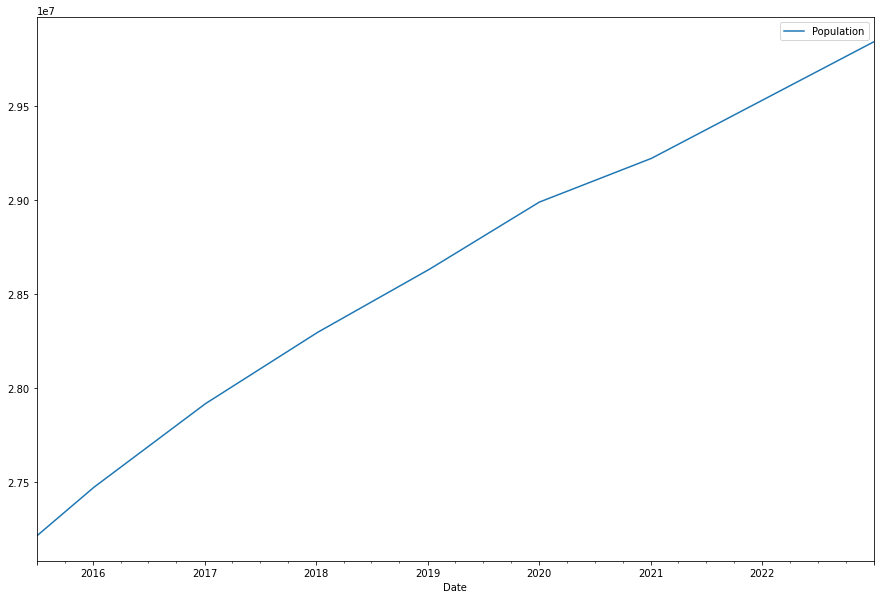

In [39]:
# Plot data
PopulationTexas.plot()

In [40]:
#########################################################
#########################################################
#%% TEXAS  Real GDP
#########################################################
#########################################################

In [41]:
###################
#%% Read and Basic Process
###################

In [42]:
# Read raw data:
RealGDPbyIndustryTexas_Raw = pd.read_csv('Real_GDP_Texas.csv', parse_dates =['date'])

RealGDPbyIndustryTexas_Raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    71 non-null     datetime64[ns]
 1   value   71 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 KB


In [43]:
# Show data
RealGDPbyIndustryTexas_Raw

,date,value
0,2005-01-01,1139658.4
1,2005-04-01,1135433.3
2,2005-07-01,1137918.6
3,2005-10-01,1152484.7
4,2006-01-01,1201785.0
...,...,...
66,2021-07-01,1815623.2
67,2021-10-01,1840893.4
68,2022-01-01,1843354.1
69,2022-04-01,1851811.8


In [44]:
# Rename, set index and select from first observation
RealGDPbyIndustryTexas = RealGDPbyIndustryTexas_Raw.copy()\
                            .rename(columns ={'date':'Date', 'value':'RealGDP'})\
                            .set_index('Date')\
                            .loc[str(FirstDemandObserwation.year):]

# Show data
RealGDPbyIndustryTexas

,RealGDP
Date,
2015-01-01,1606817.9
2015-04-01,1590408.4
2015-07-01,1608819.7
2015-10-01,1617560.7
2016-01-01,1616602.1
...,...
2021-07-01,1815623.2
2021-10-01,1840893.4
2022-01-01,1843354.1


In [45]:
# Check NA
RealGDPbyIndustryTexas.isna().sum()

RealGDP    0
dtype: int64

In [46]:
# Move date to end of quarter
RealGDPbyIndustryTexas.index = RealGDPbyIndustryTexas.index + pd.offsets.MonthEnd(3)

# Make data daily by inteprolation
RealGDPbyIndustryTexas = RealGDPbyIndustryTexas.asfreq('H')\
                                               .interpolate(method='time')

# Select date from 1-st observation
RealGDPbyIndustryTexas = RealGDPbyIndustryTexas.loc[FirstDemandObserwation:]

# Show Data
RealGDPbyIndustryTexas

,RealGDP
Date,
2015-07-01 01:00:00,1.590617e+06
2015-07-01 02:00:00,1.590625e+06
2015-07-01 03:00:00,1.590634e+06
2015-07-01 04:00:00,1.590642e+06
2015-07-01 05:00:00,1.590650e+06
...,...
2022-09-29 20:00:00,1.888802e+06
2022-09-29 21:00:00,1.888819e+06
2022-09-29 22:00:00,1.888836e+06


<AxesSubplot:xlabel='Date'>

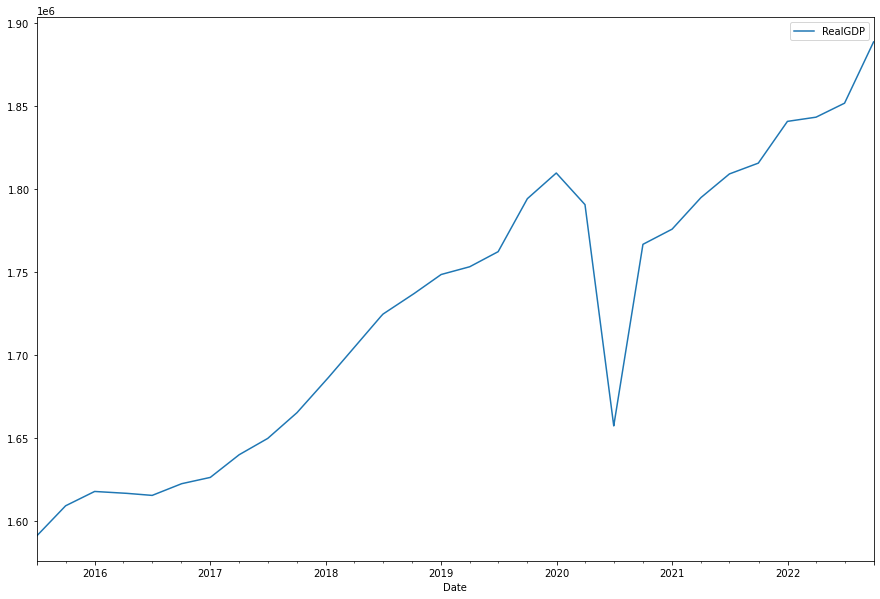

In [47]:
# Plot data
RealGDPbyIndustryTexas.plot()

In [48]:
#########################################################
#########################################################
#%% Dallas_Fed_Manufacturing_Index
#########################################################
#########################################################

In [49]:
###################
#%% Read and Basic Process
###################

In [50]:
# Read raw data:
DallasFedManufacturingIndex_Raw = pd.read_csv('Dallas_Fed_Manufacturing_Index.csv', parse_dates =['date'])

DallasFedManufacturingIndex_Raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    95 non-null     datetime64[ns]
 1   value   95 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB


In [51]:
# Show data
DallasFedManufacturingIndex_Raw

,date,value
0,2015-01-01,-4.4
1,2015-02-01,-11.2
2,2015-03-01,-17.4
3,2015-04-01,-16.0
4,2015-05-01,-20.8
...,...,...
90,2022-07-01,-22.6
91,2022-08-01,-12.9
92,2022-09-01,-17.2
93,2022-10-01,-19.4


In [52]:
# Rename, set index and select from first observation
DallasFedManufIndex = DallasFedManufacturingIndex_Raw.copy()\
                                    .rename(columns ={'date':'Date', 'value':'DallasFedManufIndex'})\
                                    .set_index('Date')

# Move date to quarter end
DallasFedManufIndex.index = DallasFedManufIndex.index + pd.offsets.MonthEnd(0)

# Make data daily by inteprolation
DallasFedManufIndex = DallasFedManufIndex.asfreq('H')\
                                          .interpolate(method='time')\
                                          .round(3)

# Select date from 1-st observation
DallasFedManufIndex = DallasFedManufIndex.loc[FirstDemandObserwation:]

# Show Data
DallasFedManufIndex

,DallasFedManufIndex
Date,
2015-07-01 01:00:00,-6.919
2015-07-01 02:00:00,-6.916
2015-07-01 03:00:00,-6.913
2015-07-01 04:00:00,-6.910
2015-07-01 05:00:00,-6.906
...,...
2022-11-29 20:00:00,-14.428
2022-11-29 21:00:00,-14.421
2022-11-29 22:00:00,-14.414


<AxesSubplot:xlabel='Date'>

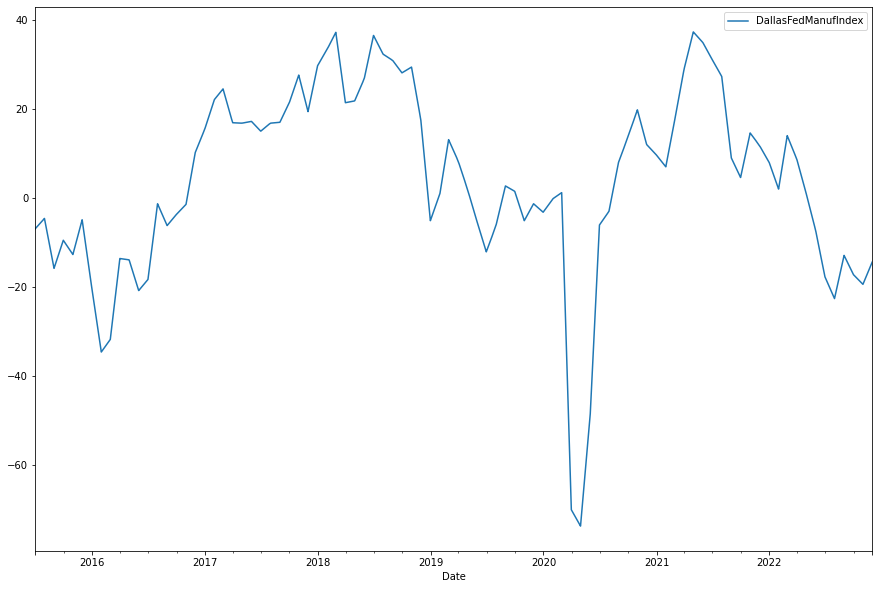

In [53]:
# Plot data
DallasFedManufIndex.plot()

In [54]:
#########################################################
#########################################################
#%% FINALL FINALL
#########################################################
#########################################################

In [55]:
# Initialize Analysis DataFrame by Demand data
AnalysisDF = TexasDemandData[['filled']]\
                                    .rename(columns={'filled':'Demand'})\
                                    .round(0)

In [56]:
# Join other dat
AnalysisDF = AnalysisDF.tz_localize(None)\
                .join( AustinWheatherData, how = 'left')\
                .join( PopulationTexas, how = 'left')\
                .join( RealGDPbyIndustryTexas, how = 'left')\
                .join( DallasFedManufIndex, how = 'left')

In [57]:
# Show data
AnalysisDF

,Demand,air_temperature,humidity,sky_cover,wind_speed,Population,RealGDP,DallasFedManufIndex
Date,,,,,,,,
2015-07-01 01:00:00,37456.0,23.0,95.0,14.0,11.5,2.721518e+07,1.590617e+06,-6.919
2015-07-01 02:00:00,35119.0,22.9,96.0,26.0,11.3,2.721523e+07,1.590625e+06,-6.916
2015-07-01 03:00:00,33638.0,22.8,95.0,22.0,10.9,2.721529e+07,1.590634e+06,-6.913
2015-07-01 04:00:00,32798.0,22.6,96.0,7.0,9.4,2.721535e+07,1.590642e+06,-6.910
2015-07-01 05:00:00,32805.0,22.5,96.0,5.0,7.1,2.721541e+07,1.590650e+06,-6.906
...,...,...,...,...,...,...,...,...
2022-12-09 06:00:00,37635.0,NaN,NaN,NaN,NaN,2.981974e+07,NaN,NaN
2022-12-09 07:00:00,40596.0,NaN,NaN,NaN,NaN,2.981977e+07,NaN,NaN
2022-12-09 08:00:00,41978.0,NaN,NaN,NaN,NaN,2.981981e+07,NaN,NaN


In [58]:
# RealGDP last observation limit data, so cut all data by it:
AnalysisDF = AnalysisDF.loc[:RealGDPbyIndustryTexas.index[-1]]

In [59]:
# Check finall data NA
AnalysisDF.isna().sum()

Demand                 0
air_temperature        0
humidity               0
sky_cover              0
wind_speed             0
Population             0
RealGDP                0
DallasFedManufIndex    0
dtype: int64

In [60]:
# Assign working day, hour, day, week variables and CDD and HDD as well
from workalendar.usa import UnitedStates
callWorkDayData = UnitedStates()

AnalysisDF = AnalysisDF\
    .assign(WorkDay = lambda x: x.index.to_series().transform(lambda y: callWorkDayData.is_working_day(y)).astype(int))\
    .assign(hour = lambda x: x.index.hour.astype(int),
            day = lambda x: x.index.isocalendar().day.astype(int),
            week = lambda x: x.index.isocalendar().week.astype(int),
            month = lambda x: x.index.month.astype(int))\
    .assign(HDD = lambda x: np.where( x['air_temperature'] <= 15, (18-x['air_temperature']).round().astype(int), 0 ),
            CDD = lambda x: np.where( x['air_temperature'] >= 24, (x['air_temperature']-21).round().astype(int), 0 ))

In [61]:
# Show finall data
AnalysisDF

,Demand,air_temperature,humidity,sky_cover,wind_speed,Population,RealGDP,DallasFedManufIndex,WorkDay,hour,day,week,month,HDD,CDD
Date,,,,,,,,,,,,,,,
2015-07-01 01:00:00,37456.0,23.0,95.0,14.0,11.5,2.721518e+07,1.590617e+06,-6.919,1,1,3,27,7,0,0
2015-07-01 02:00:00,35119.0,22.9,96.0,26.0,11.3,2.721523e+07,1.590625e+06,-6.916,1,2,3,27,7,0,0
2015-07-01 03:00:00,33638.0,22.8,95.0,22.0,10.9,2.721529e+07,1.590634e+06,-6.913,1,3,3,27,7,0,0
2015-07-01 04:00:00,32798.0,22.6,96.0,7.0,9.4,2.721535e+07,1.590642e+06,-6.910,1,4,3,27,7,0,0
2015-07-01 05:00:00,32805.0,22.5,96.0,5.0,7.1,2.721541e+07,1.590650e+06,-6.906,1,5,3,27,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 20:00:00,54135.0,28.4,33.0,0.0,9.7,2.975988e+07,1.888802e+06,-17.176,1,20,4,39,9,0,7
2022-09-29 21:00:00,51938.0,25.4,39.0,0.0,9.7,2.975991e+07,1.888819e+06,-17.182,1,21,4,39,9,0,4
2022-09-29 22:00:00,49174.0,25.0,40.0,0.0,8.7,2.975995e+07,1.888836e+06,-17.188,1,22,4,39,9,0,4
